In [7]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def weekday_word(weekday):
    if weekday==0:
        return "Monday"
    elif weekday==1:
        return "Tuesday"
    elif weekday==2:
        return "Wednesday"
    elif weekday==3:
        return "Thursday"
    elif weekday==4:
        return "Friday"
    elif weekday==5:
        return "Saturday"
    else:
        return "Sunday"
    
def is_weekend(weekday):
    return weekday in [5,6]

### Feature forklaring
- User Type: 
    - Customer = 24-hour pass or 3-day pass
    - Subscriber = Annual Member
- Gender:
    - 0 -> Unknown
    - 1 -> Male
    - 2 -> Female

In [9]:
f=pd.read_csv(r"Trips_2018.csv")

In [10]:
f.describe()

,Unnamed: 0,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender
count,1.754834e+07,1.754834e+07,1.754584e+07,1.754834e+07,1.754834e+07,1.754584e+07,1.754834e+07,1.754834e+07,1.754834e+07,1.754834e+07,1.754834e+07
mean,8.774169e+06,9.887432e+02,1.589282e+03,4.073737e+01,-7.398260e+01,1.580830e+03,4.073704e+01,-7.398281e+01,2.656141e+04,1.978993e+03,1.148613e+00
std,5.065769e+06,1.889584e+04,1.439432e+03,3.225813e-02,1.912753e-02,1.438502e+03,3.206583e-02,1.919611e-02,6.222916e+03,1.192922e+01,5.438043e-01
min,0.000000e+00,6.100000e+01,7.200000e+01,4.064654e+01,-7.402535e+01,7.200000e+01,4.064654e+01,-7.408364e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,4.387084e+06,3.580000e+02,3.800000e+02,4.071755e+01,-7.399521e+01,3.800000e+02,4.071755e+01,-7.399595e+01,2.029300e+04,1.969000e+03,1.000000e+00
50%,8.774169e+06,6.050000e+02,5.050000e+02,4.073818e+01,-7.398565e+01,5.050000e+02,4.073756e+01,-7.398602e+01,2.827000e+04,1.981000e+03,1.000000e+00
75%,1.316125e+07,1.060000e+03,3.249000e+03,4.075763e+01,-7.397283e+01,3.249000e+03,4.075725e+01,-7.397344e+01,3.185200e+04,1.989000e+03,1.000000e+00
max,1.754834e+07,1.951005e+07,3.721000e+03,4.550636e+01,-7.356891e+01,3.721000e+03,4.550636e+01,-7.356891e+01,3.583100e+04,2.002000e+03,2.000000e+00


In [11]:
f = f.rename({"Unnamed: 0": "Trip ID"}, axis="columns")
f = f.set_index("Trip ID")

In [12]:
f.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
Trip ID,,,,,,,,,,,,,
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


In [13]:
f['starttime'] = pd.to_datetime(f['starttime'], format='%Y-%m-%d %H:%M:%S.%f')
f['stoptime'] = pd.to_datetime(f['stoptime'], format='%Y-%m-%d %H:%M:%S.%f')
f['weekday']= f['starttime'].dt.weekday
f['is_weekend']=[is_weekend(el) for el in f['weekday']]
# sm_dummies=pd.get_dummies(f, columns=['usertype'])
# sm_dummies.head()

In [14]:
f.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                  float64
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_latitude              float64
end_station_longitude             float64
bikeid                              int64
usertype                           object
birth_year                          int64
gender                              int64
weekday                             int32
is_weekend                           bool
dtype: object

In [15]:
# sm_dummies.dtypes

# Looking at coordinates

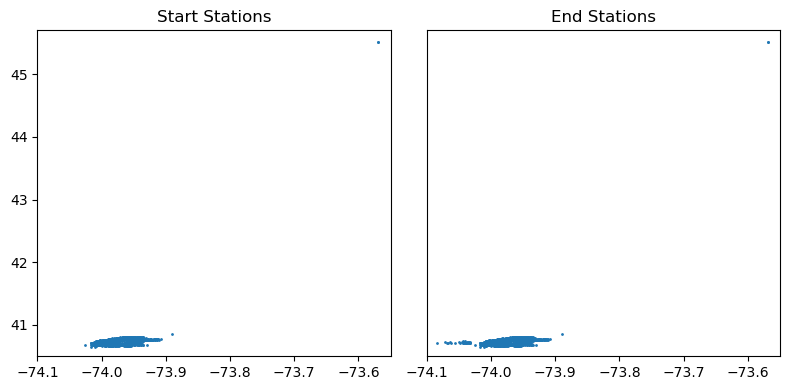

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

xlim, ylim = (-74.1, -73.55), (40.5, 45.7)
dot_size = 1

start_station_df = f.drop_duplicates(subset='start_station_id')[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
start_station_df = start_station_df.set_index("start_station_id")
start_station_df = start_station_df.rename(
    {
        "start_station_latitude": "latitude", 
        "start_station_longitude": "longitude"
    }, 
    axis="columns"
)
ax1.scatter(start_station_df['longitude'],start_station_df['latitude'],s=dot_size)
ax1.set_title("Start Stations")
ax1.set_xlim(*xlim)
ax1.set_ylim(*ylim)

end_station_df = f.drop_duplicates(subset='end_station_id')[['end_station_id', 'end_station_latitude', 'end_station_longitude']]
end_station_df = end_station_df.set_index("end_station_id")
end_station_df = end_station_df.rename(
    {
        "end_station_latitude": "latitude", 
        "end_station_longitude": "longitude"
    }, 
    axis="columns"
)
ax2.scatter(end_station_df['longitude'],end_station_df['latitude'],s=dot_size)
ax2.set_title("End Stations")
ax2.set_xlim(*xlim)
ax2.set_ylim(*ylim)
ax2.set_yticks([])

plt.tight_layout()
plt.show()

# Remove outlier

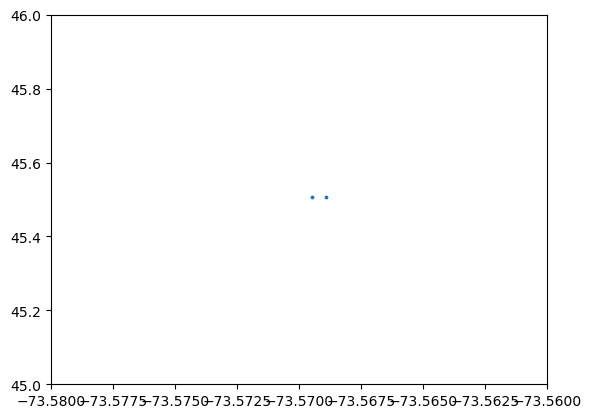

In [17]:
plt.scatter(start_station_df['longitude'], start_station_df['latitude'], s=3)
plt.xlim((-73.58, -73.56))
plt.ylim((45, 46))
plt.show()

In [18]:
start_station_df[start_station_df.longitude > -73.6]

,latitude,longitude
start_station_id,,
3488.0,45.506364,-73.569463
3650.0,45.506264,-73.568906


In [19]:
end_station_df[end_station_df.longitude > -73.6]

,latitude,longitude
end_station_id,,
3488.0,45.506364,-73.569463
3650.0,45.506264,-73.568906


In [20]:
f[
    (f.start_station_id == 3488.0) &
    (f.start_station_id != f.end_station_id)
]

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,weekday,is_weekend
Trip ID,,,,,,,,,,,,,,,


In [21]:
f[
    (f.end_station_id == 3488.0) &
    (f.start_station_id != f.end_station_id)
]

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,weekday,is_weekend
Trip ID,,,,,,,,,,,,,,,
8772457,1634200,2018-07-18 18:27:51.511,2018-08-06 16:24:32.388,3036.0,40.662908,-73.999722,3488.0,45.506364,-73.569463,24354,Subscriber,1988,1,2,False


In [22]:
f[
    (f.start_station_id == 3650.0) &
    (f.start_station_id != f.end_station_id)
]

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,weekday,is_weekend
Trip ID,,,,,,,,,,,,,,,


In [23]:
f[
    (f.end_station_id == 3650.0) &
    (f.start_station_id != f.end_station_id)
]

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,weekday,is_weekend
Trip ID,,,,,,,,,,,,,,,


In [24]:
f[
    (f.start_station_id == 3488) | (f.end_station_id == 3488) |
    (f.start_station_id == 3650) | (f.end_station_id == 3650)
].describe()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender,weekday
count,8.200000e+01,82,82,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,2.954804e+04,2018-03-14 21:46:53.854036736,2018-03-15 05:59:22.416878080,3636.585366,45.447203,-73.574180,3642.097561,45.506269,-73.568933,23651.158537,1985.792683,1.012195,1.378049
min,6.200000e+01,2018-01-08 16:03:59.375000,2018-01-08 16:09:41.338000,3036.000000,40.662908,-73.999722,3488.000000,45.506264,-73.569463,17667.000000,1969.000000,0.000000,0.000000
25%,2.235000e+02,2018-01-26 10:59:14.185999872,2018-01-26 12:46:01.522750208,3650.000000,45.506264,-73.568906,3650.000000,45.506264,-73.568906,21928.000000,1986.000000,1.000000,0.000000
50%,9.390000e+02,2018-02-20 14:11:07.361499904,2018-02-20 14:12:41.880000,3650.000000,45.506264,-73.568906,3650.000000,45.506264,-73.568906,24354.000000,1986.000000,1.000000,1.000000
75%,2.653500e+03,2018-05-08 17:10:19.270750208,2018-05-08 17:19:55.421250048,3650.000000,45.506264,-73.568906,3650.000000,45.506264,-73.568906,24354.000000,1986.000000,1.000000,3.000000
max,1.634200e+06,2018-07-18 18:27:51.511000,2018-08-06 16:24:32.388000,3650.000000,45.506364,-73.568906,3650.000000,45.506364,-73.568906,24354.000000,1988.000000,2.000000,4.000000
std,1.827257e+05,NaN,NaN,73.784128,0.534860,0.047574,35.110974,0.000022,0.000121,1256.116408,2.752049,0.248149,1.329998


We have two outliers stations with id 3448 and 3650. We found that they are both placed right next to one another in Montreal, Canada. From the above cells, it is apparent that all but one trips completed with start or end point in Montreal (station 3488 and 3650) are trips in Montreal only.

There is a single trip from Brooklyn (station 3036) to Montreal (station 3488). It's duration is 18.9 days and out of 17 million trips completed, this one is the only one travelling to Montreal. Therefore we classify stations in Montreal as not relevant and outliers.

In [25]:
f = f.drop(
    f[
        (f.start_station_id == 3488) | (f.end_station_id == 3488) |
        (f.start_station_id == 3650) | (f.end_station_id == 3650)
    ].index
)

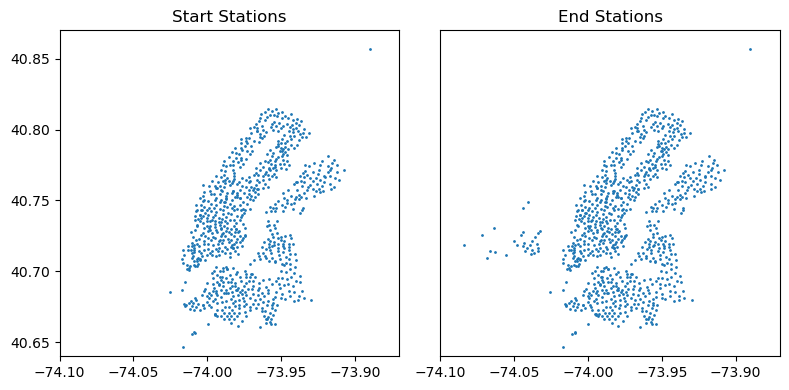

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

xlim, ylim = (-74.1, -73.87), (40.64, 40.87)
dot_size = 1

start_station_df = f.drop_duplicates(subset='start_station_id')[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
start_station_df = start_station_df.set_index("start_station_id")
start_station_df = start_station_df.rename(
    {
        "start_station_latitude": "latitude", 
        "start_station_longitude": "longitude"
    }, 
    axis="columns"
)
ax1.scatter(start_station_df['longitude'],start_station_df['latitude'],s=dot_size)
ax1.set_title("Start Stations")
ax1.set_xlim(*xlim)
ax1.set_ylim(*ylim)

end_station_df = f.drop_duplicates(subset='end_station_id')[['end_station_id', 'end_station_latitude', 'end_station_longitude']]
end_station_df = end_station_df.set_index("end_station_id")
end_station_df = end_station_df.rename(
    {
        "end_station_latitude": "latitude", 
        "end_station_longitude": "longitude"
    }, 
    axis="columns"
)
ax2.scatter(end_station_df['longitude'],end_station_df['latitude'],s=dot_size)
ax2.set_title("End Stations")
ax2.set_xlim(*xlim)
ax2.set_ylim(*ylim)
ax2.set_yticks([])

plt.tight_layout()
plt.show()

### Classifying the stations with ID: NaN

We find that a great deal of stations have ID = NaN. So we try and plot them to find their location.

In [27]:
start_ids = np.unique(f.start_station_id)
end_ids = np.unique(f.end_station_id)
print(f"Number of NaN values in start_station_id: {f.start_station_id.isna().sum()}")
print(f"Number of NaN values in end_station_id: {f.end_station_id.isna().sum()}")
start_station_df[start_station_df.index.isna()]

Number of NaN values in start_station_id: 2497
Number of NaN values in end_station_id: 2497


,latitude,longitude
start_station_id,,
NaN,40.857,-73.89


2497 trips have a station ID with NaN-value

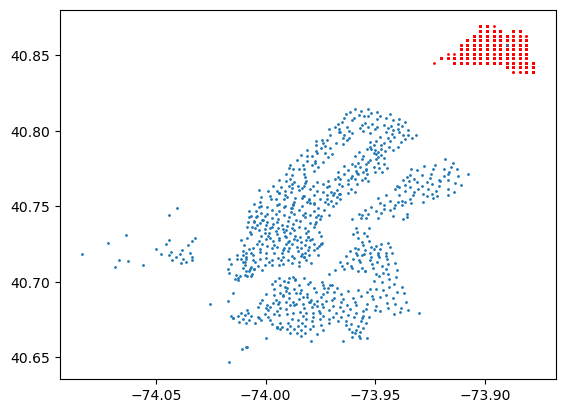

In [28]:
f_nan = f[f.start_station_id.isna()][['start_station_longitude', 'start_station_latitude']]
plt.scatter(f_nan.start_station_longitude, f_nan.start_station_latitude, s=1, c='r', label="NaN-station")
plt.scatter(end_station_df['longitude'], end_station_df['latitude'], s=1)
plt.show()

In [29]:
print("\nCheck: Are the placements different? If all 0, then all placements same")
print(np.unique(f[f.start_station_id.isna()].start_station_longitude) - np.unique(f[f.start_station_id.isna()].end_station_longitude))
print(np.unique(f[f.end_station_id.isna()].start_station_longitude) - np.unique(f[f.end_station_id.isna()].end_station_longitude))
print(np.unique(f[f.start_station_id.isna()].start_station_latitude) - np.unique(f[f.start_station_id.isna()].end_station_latitude))
print(np.unique(f[f.end_station_id.isna()].start_station_latitude) - np.unique(f[f.end_station_id.isna()].end_station_latitude))

print("\nValues for longitude and latitude")
print(np.unique(f[f.start_station_id.isna()].start_station_longitude))
print(np.unique(f[f.start_station_id.isna()].start_station_latitude))

print(f"\nNumber of stations with NaN-value as ID: {len(np.unique(f[f.start_station_id.isna()].start_station_longitude))}")


Check: Are the placements different? If all 0, then all placements same
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Values for longitude and latitude
[-73.923 -73.92  -73.917 -73.914 -73.911 -73.908 -73.905 -73.902 -73.899
 -73.896 -73.893 -73.89  -73.887 -73.884 -73.881 -73.878]
[40.839 40.842 40.845 40.848 40.851 40.854 40.857 40.86  40.863 40.866
 40.869]

Number of stations with NaN-value as ID: 16


Okay, all 16 NaN-ID-stations are located in a single 'cluster' or grouping.
Looking at the placement in a map, the red grouping lies in the Bronx area North of New York. Also as a result of our plotting the single blue dot is the result of dropping duplicates on the ID's. This means that it, in previous plots, represented all the red dots, we now found.

We check whether or not we have data on any trips leaving this grouping. 

In [30]:
f[(f.start_station_id.isna()) & (f.end_station_id.notna())]

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,weekday,is_weekend
Trip ID,,,,,,,,,,,,,,,


In [31]:
f[(f.start_station_id.notna()) & (f.end_station_id.isna())]

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,weekday,is_weekend
Trip ID,,,,,,,,,,,,,,,


Okay, no trips from a NaN-ID-station leaves the grouping in the Bronx area. Hence, they have no implication on clusters in the central New York area. Since that is the case they wont be important for rebalancing the bike locations, so we classicy them as outliers

In [32]:
f = f.dropna()

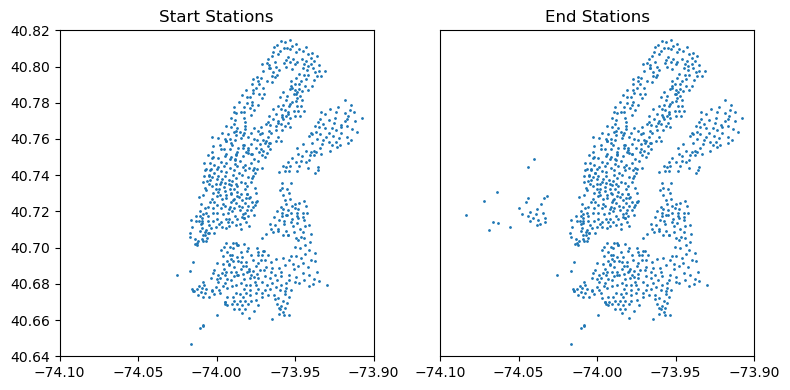

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

xlim, ylim = (-74.1, -73.9), (40.64, 40.82)
dot_size = 1

start_station_df = f.drop_duplicates(subset='start_station_id')[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
start_station_df = start_station_df.set_index("start_station_id")
start_station_df = start_station_df.rename(
    {
        "start_station_latitude": "latitude", 
        "start_station_longitude": "longitude"
    }, 
    axis="columns"
)
ax1.scatter(start_station_df['longitude'],start_station_df['latitude'],s=dot_size)
ax1.set_title("Start Stations")
ax1.set_xlim(*xlim)
ax1.set_ylim(*ylim)

end_station_df = f.drop_duplicates(subset='end_station_id')[['end_station_id', 'end_station_latitude', 'end_station_longitude']]
end_station_df = end_station_df.set_index("end_station_id")
end_station_df = end_station_df.rename(
    {
        "end_station_latitude": "latitude", 
        "end_station_longitude": "longitude"
    }, 
    axis="columns"
)
ax2.scatter(end_station_df['longitude'],end_station_df['latitude'],s=dot_size)
ax2.set_title("End Stations")
ax2.set_xlim(*xlim)
ax2.set_ylim(*ylim)
ax2.set_yticks([])

plt.tight_layout()
plt.show()

## K-means

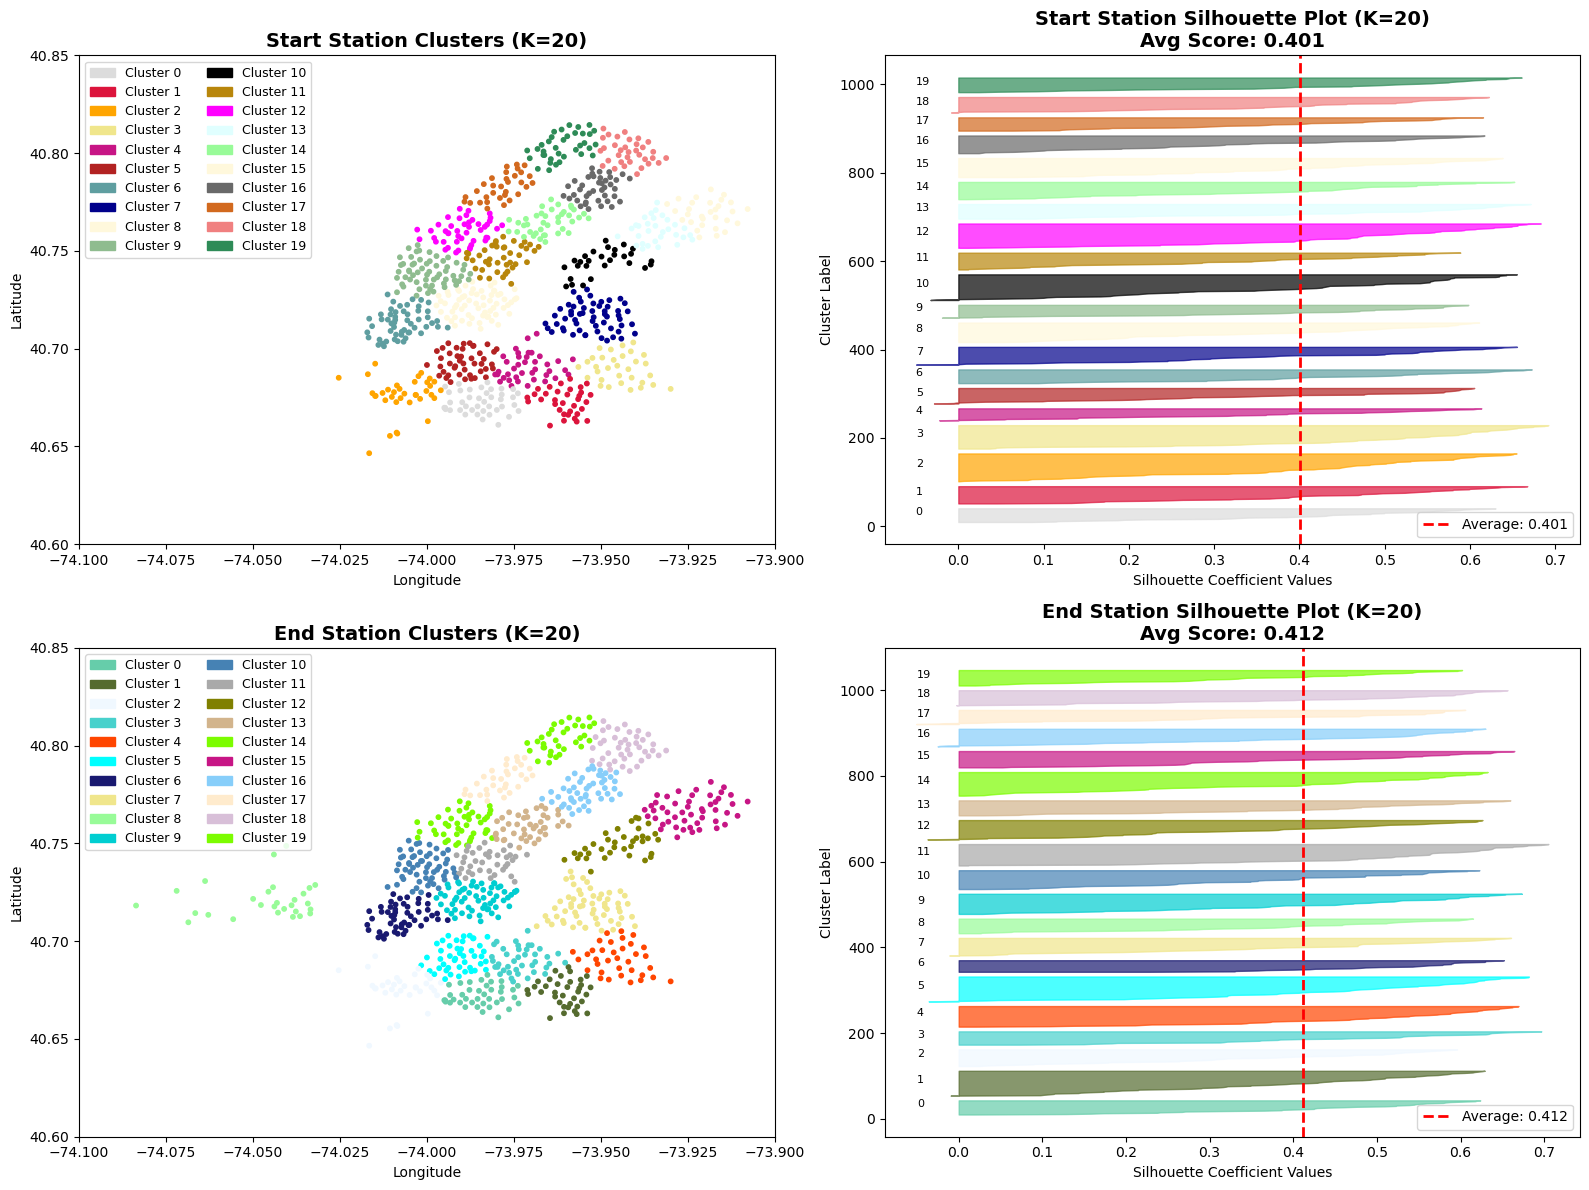

Start Station Average Silhouette Score: 0.401
End Station Average Silhouette Score: 0.412


In [34]:
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import random

K=20

# Fit K-means for start stations
k_start=KMeans(K, random_state=42, n_init=30)
k_end=KMeans(K, random_state=42, n_init=30)

k_start.fit(start_station_df)
k_end.fit(end_station_df)
centroids_start = k_start.cluster_centers_
centroids_end = k_end.cluster_centers_

# Fixing labelling start
order = np.argsort(centroids_start[:, 0])
mapping = {old: new for new, old in enumerate(order)}
fix_labels_start = np.array([mapping[label] for label in k_start.labels_])

# Fixing labelling end
order = np.argsort(centroids_end[:, 0])
mapping = {old: new for new, old in enumerate(order)}
fix_labels_end = np.array([mapping[label] for label in k_end.labels_])

dt_clusters_start=start_station_df.copy()
dt_clusters_start['cluster']= fix_labels_start

dt_clusters_end=end_station_df.copy()
dt_clusters_end['cluster']=fix_labels_end

# Generate colors
num_colors=K
colors=list(mcolors.CSS4_COLORS.keys())
cluster_colors_start = random.choices(colors,k=K)
cluster_colors_end = random.choices(colors,k=K)

# Prepare data for start stations
x_points_start=dt_clusters_start["longitude"]
y_points_start=dt_clusters_start["latitude"]
labels_start = dt_clusters_start["cluster"]
x_start=[]
y_start=[]
c_start=[]
for label, x, y in zip(labels_start, x_points_start, y_points_start):
    if label == -1:
        continue
    x_start.append(x)
    y_start.append(y)
    c_start.append(cluster_colors_start[label])

# Prepare data for end stations
x_points_end=dt_clusters_end["longitude"]
y_points_end=dt_clusters_end["latitude"]
labels_end = dt_clusters_end["cluster"]
x_end=[]
y_end=[]
c_end=[]
for label, x, y in zip(labels_end, x_points_end, y_points_end):
    if label==-1:
        continue
    x_end.append(x)
    y_end.append(y)
    c_end.append(cluster_colors_end[label])

# Calculate silhouette scores
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

silhouette_avg_start = silhouette_score(start_station_df, k_start.labels_)
sample_silhouette_values_start = silhouette_samples(start_station_df, k_start.labels_)

silhouette_avg_end = silhouette_score(end_station_df, k_end.labels_)
sample_silhouette_values_end = silhouette_samples(end_station_df, k_end.labels_)

# Create combined plot with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Start Station Clusters
ax1 = axes[0, 0]
ax1.scatter(x_start, y_start, s=10, c=c_start)
ax1.set_xlim(-74.1, -73.9)
ax1.set_ylim(40.6, 40.85)
ax1.set_title(f'Start Station Clusters (K={K})', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
legend_patches_start = [Patch(color=cluster_colors_start[i], label=f"Cluster {i}") for i in range(K)]
ax1.legend(handles=legend_patches_start, loc='upper left', fontsize=9, ncol=2)

# Plot 2: Start Station Silhouette Plot
ax2 = axes[0, 1]
y_lower = 10
for i in range(K):
    ith_cluster_silhouette_values = sample_silhouette_values_start[k_start.labels_ == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cluster_colors_start[i]
    ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=8)
    y_lower = y_upper + 10
ax2.set_title(f"Start Station Silhouette Plot (K={K})\nAvg Score: {silhouette_avg_start:.3f}", 
              fontsize=14, fontweight='bold')
ax2.set_xlabel("Silhouette Coefficient Values")
ax2.set_ylabel("Cluster Label")
ax2.axvline(x=silhouette_avg_start, color="red", linestyle="--", linewidth=2, 
            label=f"Average: {silhouette_avg_start:.3f}")
ax2.legend()

# Plot 3: End Station Clusters
ax3 = axes[1, 0]
ax3.scatter(x_end, y_end, s=10, c=c_end)
ax3.set_xlim(-74.1, -73.9)
ax3.set_ylim(40.6, 40.85)
ax3.set_title(f'End Station Clusters (K={K})', fontsize=14, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
legend_patches_end = [Patch(color=cluster_colors_end[i], label=f"Cluster {i}") for i in range(K)]
ax3.legend(handles=legend_patches_end, loc='upper left', fontsize=9, ncol=2)

# Plot 4: End Station Silhouette Plot
ax4 = axes[1, 1]
y_lower = 10
for i in range(K):
    ith_cluster_silhouette_values = sample_silhouette_values_end[k_end.labels_ == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cluster_colors_end[i]
    ax4.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax4.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=8)
    y_lower = y_upper + 10
ax4.set_title(f"End Station Silhouette Plot (K={K})\nAvg Score: {silhouette_avg_end:.3f}", 
              fontsize=14, fontweight='bold')
ax4.set_xlabel("Silhouette Coefficient Values")
ax4.set_ylabel("Cluster Label")
ax4.axvline(x=silhouette_avg_end, color="red", linestyle="--", linewidth=2, 
            label=f"Average: {silhouette_avg_end:.3f}")
ax4.legend()

plt.tight_layout()
plt.show()

print(f"Start Station Average Silhouette Score: {silhouette_avg_start:.3f}")
print(f"End Station Average Silhouette Score: {silhouette_avg_end:.3f}")

# Load a fixed labelling from file

In [35]:
# np.savetxt('fix_labels_end.txt', fix_labels_end) # for updating the fixed cluster labelling used


fixed_cluster_labels = np.loadtxt('fix_labels_end.txt')
dt_clusters_all = dt_clusters_end.copy() # All stations are represented in end_station_id column
dt_clusters_all['cluster'] = fixed_cluster_labels

# Connect clusters with the 17 mio data frame

In [36]:
df_merged_start = f.merge(
    dt_clusters_all['cluster'], 
    left_on='start_station_id', 
    right_index=True, 
    how='left'
)
# df_merged_start = df_merged_start.drop(columns=['Unnamed: 0'])

df_merged_end = f.merge(
    dt_clusters_all['cluster'], 
    left_on='end_station_id', 
    right_index=True, 
    how='left'
)

In [37]:
np.unique(dt_clusters_all[dt_clusters_all.cluster == 12].index)

array([3118., 3119., 3120., 3121., 3122., 3123., 3124., 3125., 3126.,
       3127., 3128., 3129., 3130., 3221., 3554., 3555., 3556., 3557.,
       3559., 3560., 3564., 3565., 3567., 3606., 3608., 3611., 3613.,
       3615., 3618., 3620., 3625., 3646., 3647., 3654., 3704., 3716.])

# Investigating a cluster

In [38]:
cluster_12_departures = df_merged_start[df_merged_start["cluster"] == 12].copy()
cluster_12_arrivals = df_merged_end[df_merged_end['cluster'] == 12].copy()
cluster_12_departures.size, cluster_12_arrivals.size

(3567280, 3580752)

In [39]:
cluster_12_departures.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,weekday,is_weekend,cluster
Trip ID,,,,,,,,,,,,,,,,
493802,275,2018-01-01 10:20:07.330,2018-01-01 10:24:42.944,3118.0,40.73555,-73.95284,3119.0,40.742327,-73.954117,16417,Subscriber,1978,1,0,False,12.0
493803,344,2018-01-01 11:31:47.933,2018-01-01 11:37:32.322,3118.0,40.73555,-73.95284,3119.0,40.742327,-73.954117,32458,Subscriber,1975,2,0,False,12.0
493804,3632,2018-01-02 07:13:13.179,2018-01-02 08:13:45.342,3118.0,40.73555,-73.95284,3119.0,40.742327,-73.954117,16417,Subscriber,1978,1,1,False,12.0
493805,2128,2018-01-02 07:26:05.037,2018-01-02 08:01:33.986,3118.0,40.73555,-73.95284,315.0,40.703554,-74.006702,32153,Subscriber,1967,2,1,False,12.0
493806,432,2018-01-02 07:53:00.318,2018-01-02 08:00:12.926,3118.0,40.73555,-73.95284,3119.0,40.742327,-73.954117,31204,Subscriber,1983,1,1,False,12.0


# Data visualization for a cluster

In [40]:
# Make sure starttime is a datetime
cluster_12_departures['starttime'] = pd.to_datetime(cluster_12_departures['starttime'])

# Extract date and hour
cluster_12_departures['date'] = cluster_12_departures['starttime'].dt.date
cluster_12_departures['hour'] = cluster_12_departures['starttime'].dt.hour

# Group by date and hour, count trips
trips_per_hour = cluster_12_departures.groupby(['date', 'hour']).size().reset_index(name='num_trips')
trips_per_hour[:25]


,date,hour,num_trips
0,2018-01-01,0,1
1,2018-01-01,1,2
2,2018-01-01,2,2
3,2018-01-01,4,1
4,2018-01-01,7,1
5,2018-01-01,9,2
6,2018-01-01,10,2
7,2018-01-01,11,2
8,2018-01-01,12,2
9,2018-01-01,13,3


In [41]:

trips_per_hour['datetime'] = pd.to_datetime(trips_per_hour['date'].astype(str)) + pd.to_timedelta(trips_per_hour['hour'], unit='h')
trips_per_hour.set_index('datetime', inplace=True)
trips_per_hour.drop(columns=['date'], inplace=True)
trips_per_hour.head()

,hour,num_trips
datetime,,
2018-01-01 00:00:00,0,1
2018-01-01 01:00:00,1,2
2018-01-01 02:00:00,2,2
2018-01-01 04:00:00,4,1
2018-01-01 07:00:00,7,1


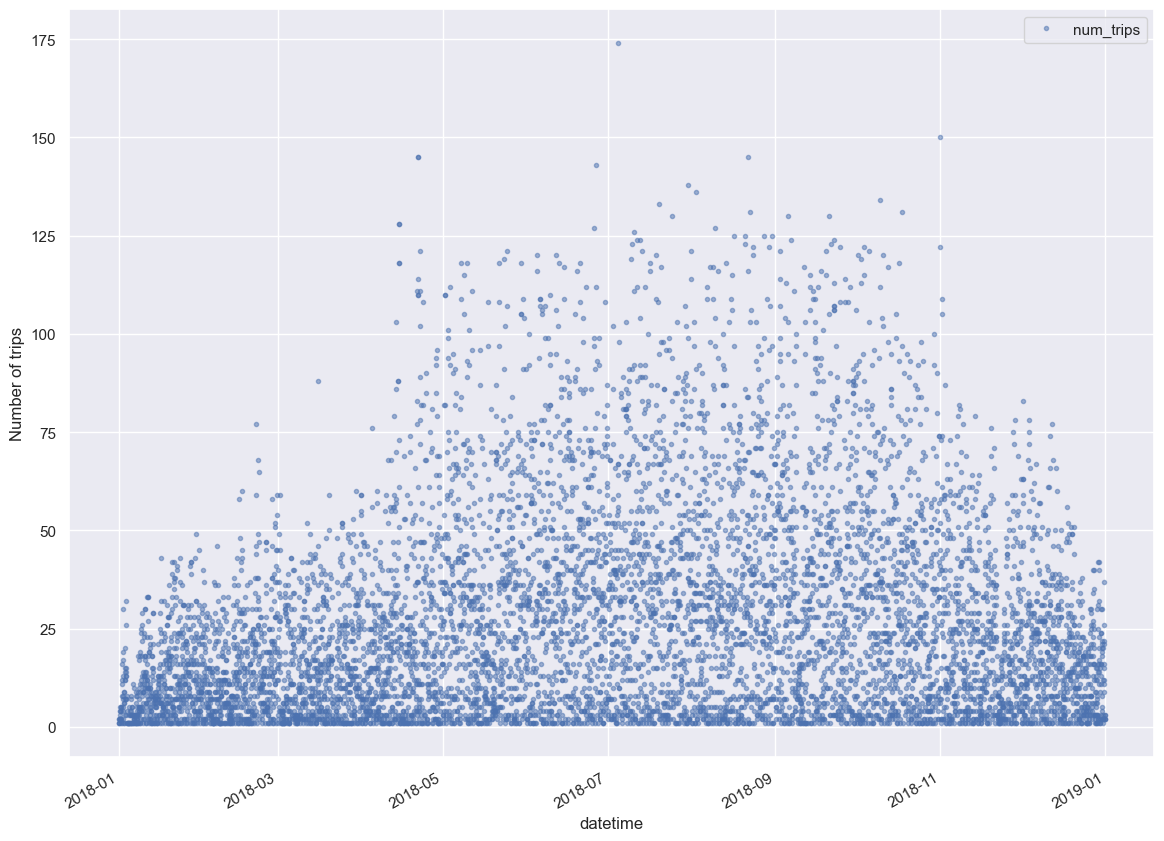

In [42]:
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(14, 5)})
cols_plot = ['num_trips']
axes = trips_per_hour[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(14, 11), subplots=True)
axes[0].set_ylabel('Number of trips')
plt.show()

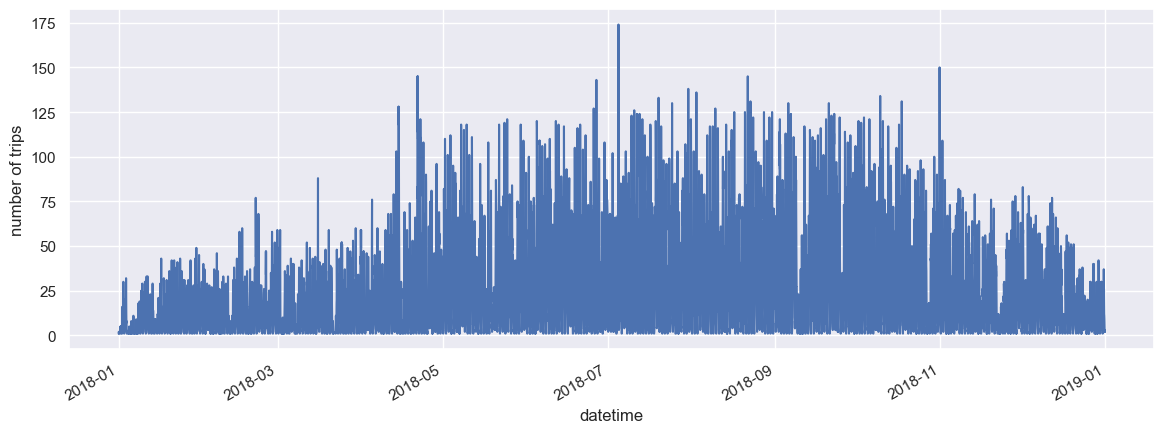

In [43]:
ax = trips_per_hour.loc['2018', 'num_trips'].plot()
ax.set_ylabel('number of trips')
plt.show()

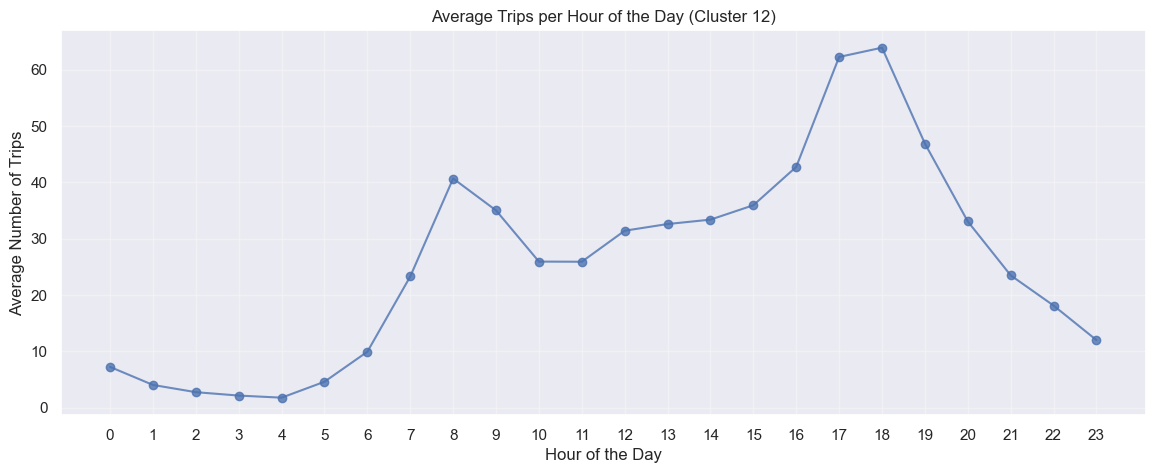

In [44]:
# Average trips per hour (0-23) across all days
avg_trips_by_hour = trips_per_hour.groupby('hour')['num_trips'].mean()
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(14, 5)})

# Plot average trips by hour
avg_trips_by_hour.plot(marker='o', linestyle='-', alpha=0.8)

plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Trips')
plt.title('Average Trips per Hour of the Day (Cluster 12)')
plt.xticks(range(0,24))  # ensure all hours are labeled
plt.grid(True, alpha=0.3)
plt.show()


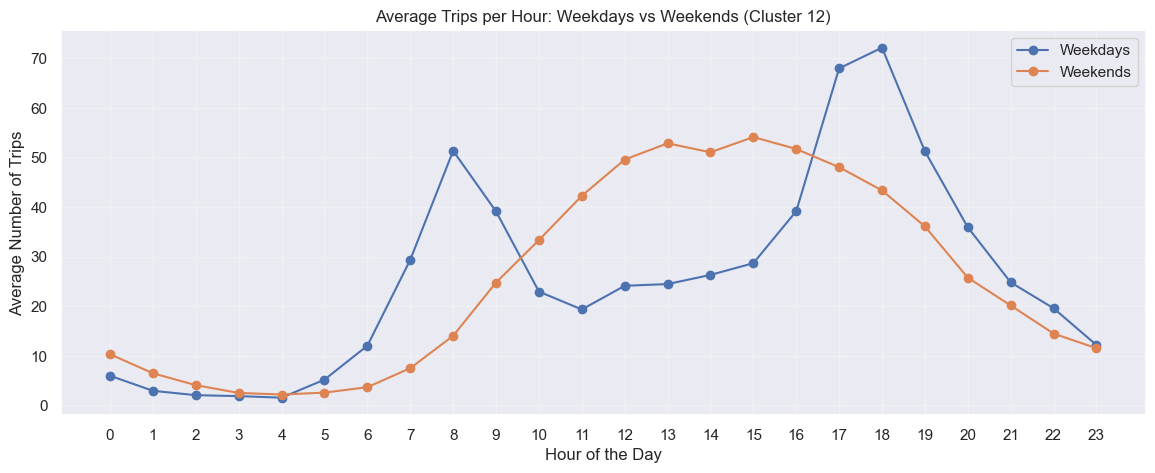

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract hour from datetime index if not already present
trips_per_hour['hour'] = trips_per_hour.index.hour
trips_per_hour['is_weekend'] = trips_per_hour.index.weekday >= 5

# Average trips per hour for weekdays
avg_weekday = trips_per_hour[~trips_per_hour['is_weekend']].groupby('hour')['num_trips'].mean()

# Average trips per hour for weekends
avg_weekend = trips_per_hour[trips_per_hour['is_weekend']].groupby('hour')['num_trips'].mean()

# Plot
sns.set(rc={'figure.figsize':(14,5)})
plt.plot(avg_weekday.index, avg_weekday.values, marker='o', linestyle='-', label='Weekdays')
plt.plot(avg_weekend.index, avg_weekend.values, marker='o', linestyle='-', label='Weekends')

plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Trips')
plt.title('Average Trips per Hour: Weekdays vs Weekends (Cluster 12)')
plt.xticks(range(0,24))
plt.grid(alpha=0.3)
plt.legend()
plt.show()


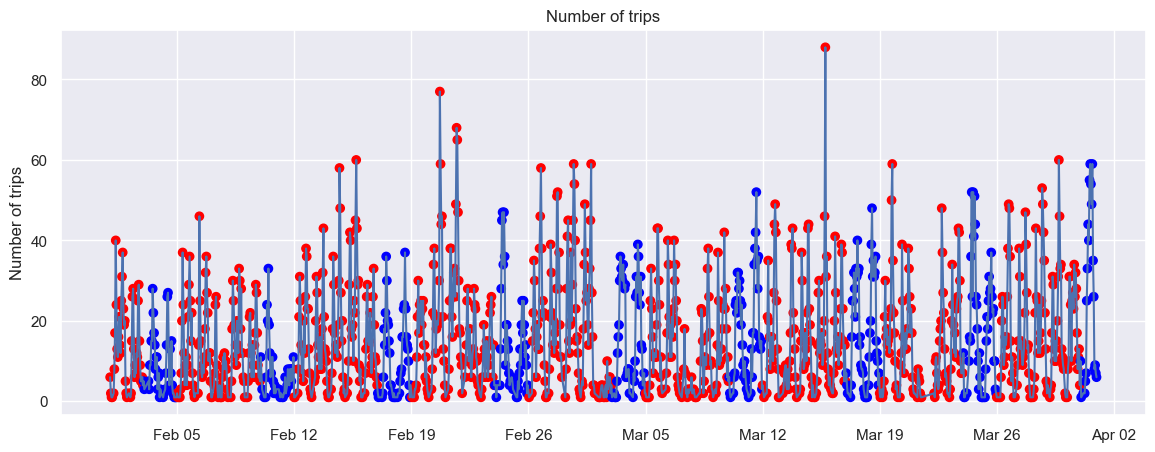

In [46]:
import matplotlib.dates as mdates
weekends=trips_per_hour.loc['2018-02':'2018-03', 'num_trips'].index.weekday>=5
colors=['blue' if x else 'red' for x in weekends]
fig, ax = plt.subplots()
ax.plot(trips_per_hour.loc['2018-02':'2018-03', 'num_trips'])
ax.scatter(trips_per_hour.loc['2018-02':'2018-03'].index, trips_per_hour.loc['2018-02':'2018-03', 'num_trips'], marker='o', linestyle='-', c=colors)
ax.set_ylabel('Number of trips')
ax.set_title('Number of trips')

# To better visualize the weekly seasonality in electricity consumption 
# we add vertical gridlines on a weekly time scale

# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

# Investigating all the data

In [47]:


# Make sure starttime is a datetime
df_merged_start['starttime'] = pd.to_datetime(df_merged_start['starttime'])

# Extract date and hour
df_merged_start['date'] = df_merged_start['starttime'].dt.date
df_merged_start['hour'] = df_merged_start['starttime'].dt.hour

# Group by date and hour, count trips
trips_per_hour_all = df_merged_start.groupby(['date', 'hour']).size().reset_index(name='num_trips')

trips_per_hour_all['datetime'] = pd.to_datetime(trips_per_hour_all['date'].astype(str)) + pd.to_timedelta(trips_per_hour_all['hour'], unit='h')
trips_per_hour_all.set_index('datetime', inplace=True)
trips_per_hour_all.drop(columns=['date'], inplace=True)

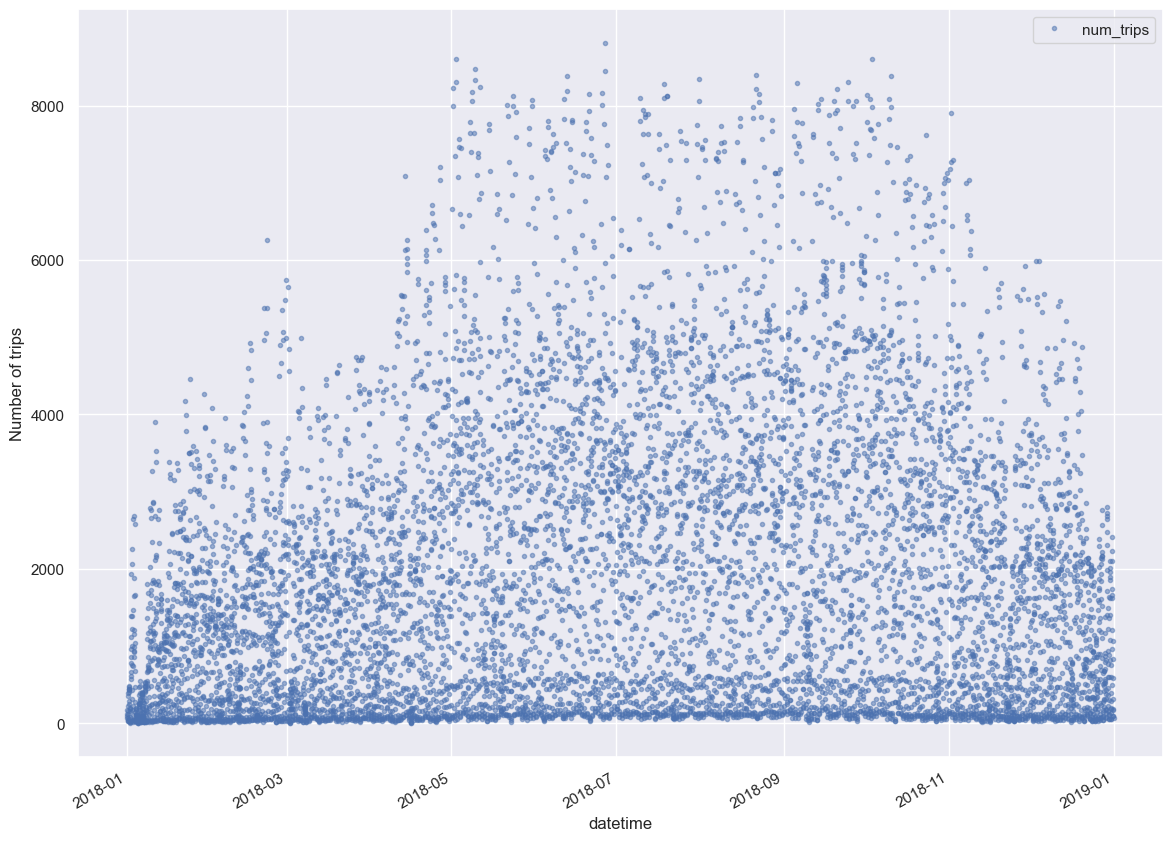

In [48]:
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(14, 5)})
cols_plot = ['num_trips']
axes = trips_per_hour_all[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(14, 11), subplots=True)
for ax in axes:
    ax.set_ylabel('Number of trips')

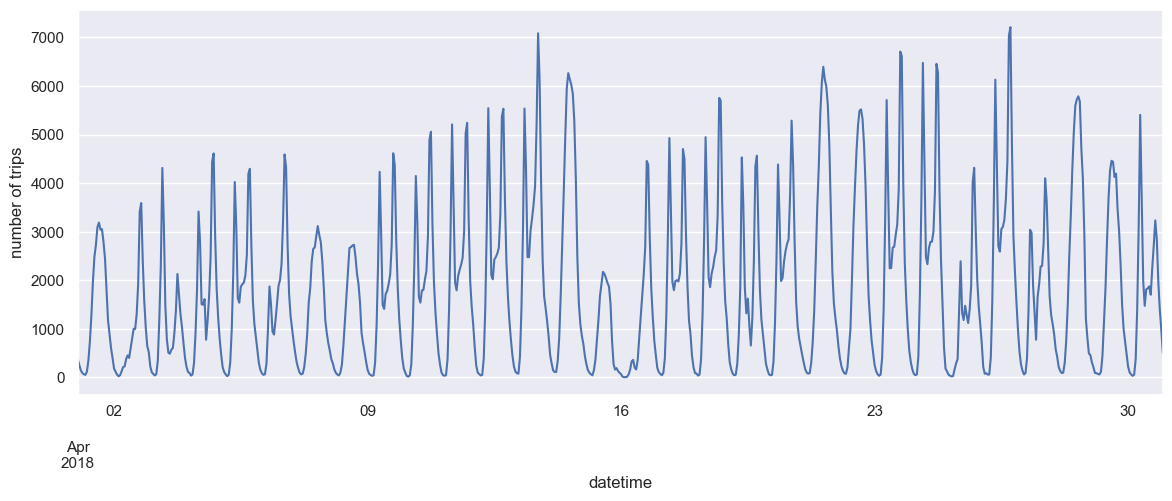

In [49]:
ax = trips_per_hour_all.loc['2018-04', 'num_trips'].plot()
ax.set_ylabel('number of trips')
plt.show()

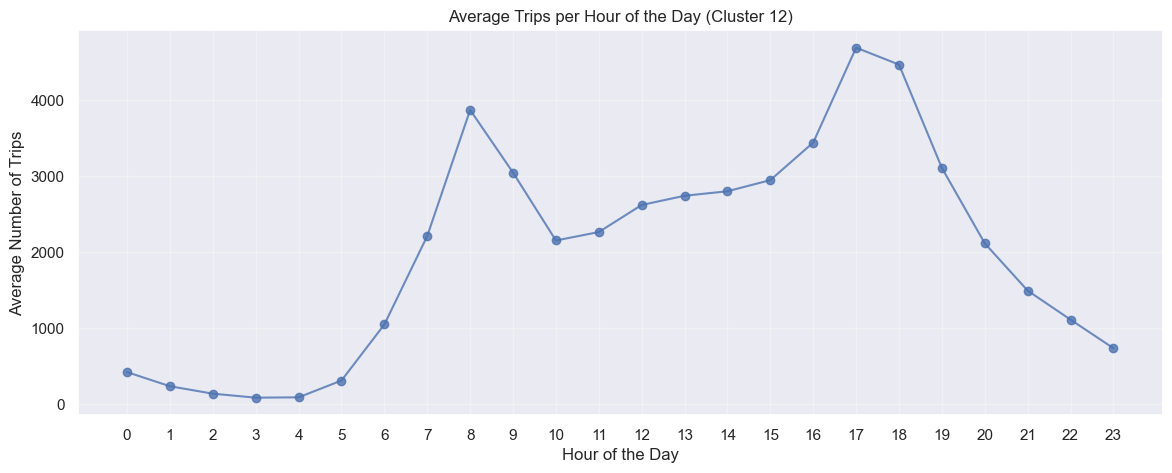

In [50]:
# Average trips per hour (0-23) across all days
avg_trips_by_hour_all = trips_per_hour_all.groupby('hour')['num_trips'].mean()
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize':(14, 5)})

# Plot average trips by hour
avg_trips_by_hour_all.plot(marker='o', linestyle='-', alpha=0.8)

plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Trips')
plt.title('Average Trips per Hour of the Day (Cluster 12)')
plt.xticks(range(0,24))  # ensure all hours are labeled
plt.grid(True, alpha=0.3)
plt.show()

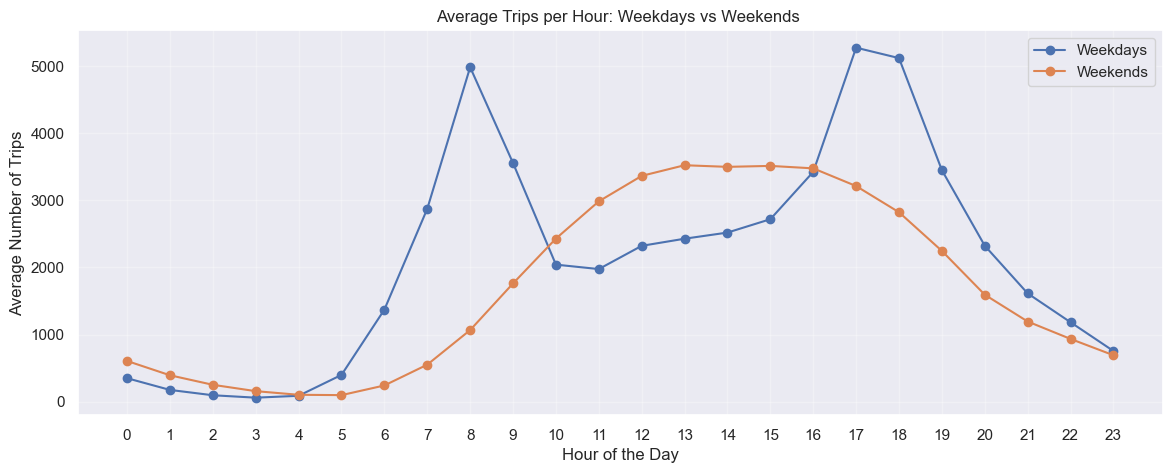

In [51]:

# Extract hour from datetime index if not already present
trips_per_hour_all['hour'] = trips_per_hour_all.index.hour
trips_per_hour_all['is_weekend'] = trips_per_hour_all.index.weekday >= 5

# Average trips per hour for weekdays
avg_weekday = trips_per_hour_all[~trips_per_hour_all['is_weekend']].groupby('hour')['num_trips'].mean()

# Average trips per hour for weekends
avg_weekend = trips_per_hour_all[trips_per_hour_all['is_weekend']].groupby('hour')['num_trips'].mean()

# Plot
sns.set(rc={'figure.figsize':(14,5)})
plt.plot(avg_weekday.index, avg_weekday.values, marker='o', linestyle='-', label='Weekdays')
plt.plot(avg_weekend.index, avg_weekend.values, marker='o', linestyle='-', label='Weekends')

plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Trips')
plt.title('Average Trips per Hour: Weekdays vs Weekends ')
plt.xticks(range(0,24))
plt.grid(alpha=0.3)
plt.legend()
plt.show()

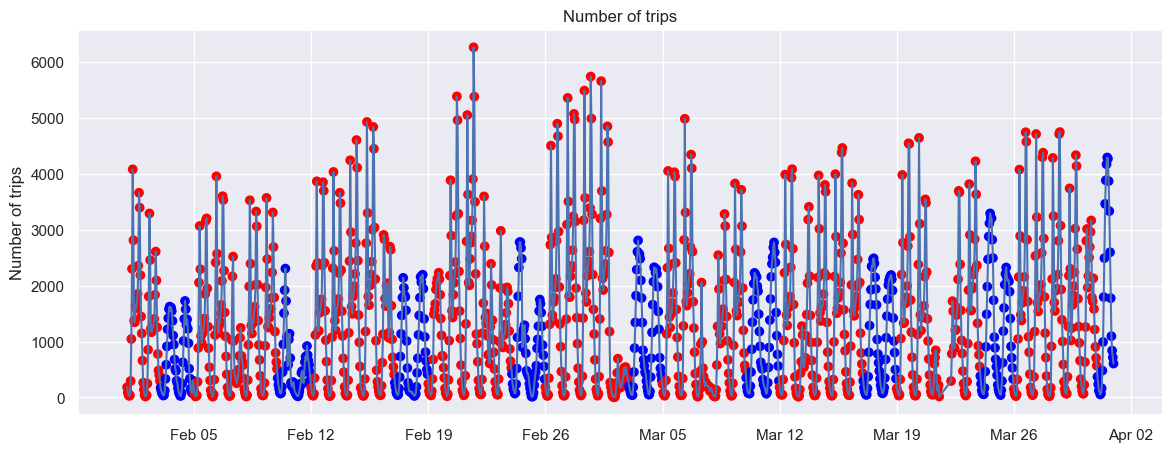

In [52]:
weekends=trips_per_hour_all.loc['2018-02':'2018-03', 'num_trips'].index.weekday>=5
colors=['blue' if x else 'red' for x in weekends]
fig, ax = plt.subplots()
ax.plot(trips_per_hour_all.loc['2018-02':'2018-03', 'num_trips'])
ax.scatter(trips_per_hour_all.loc['2018-02':'2018-03'].index, trips_per_hour_all.loc['2018-02':'2018-03', 'num_trips'], marker='o', linestyle='-', c=colors)
ax.set_ylabel('Number of trips')
ax.set_title('Number of trips')

# To better visualize the weekly seasonality in electricity consumption 
# we add vertical gridlines on a weekly time scale

# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

In [53]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(trips_per_hour_all['num_trips'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.135703
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# Exploring seasonality in all the data

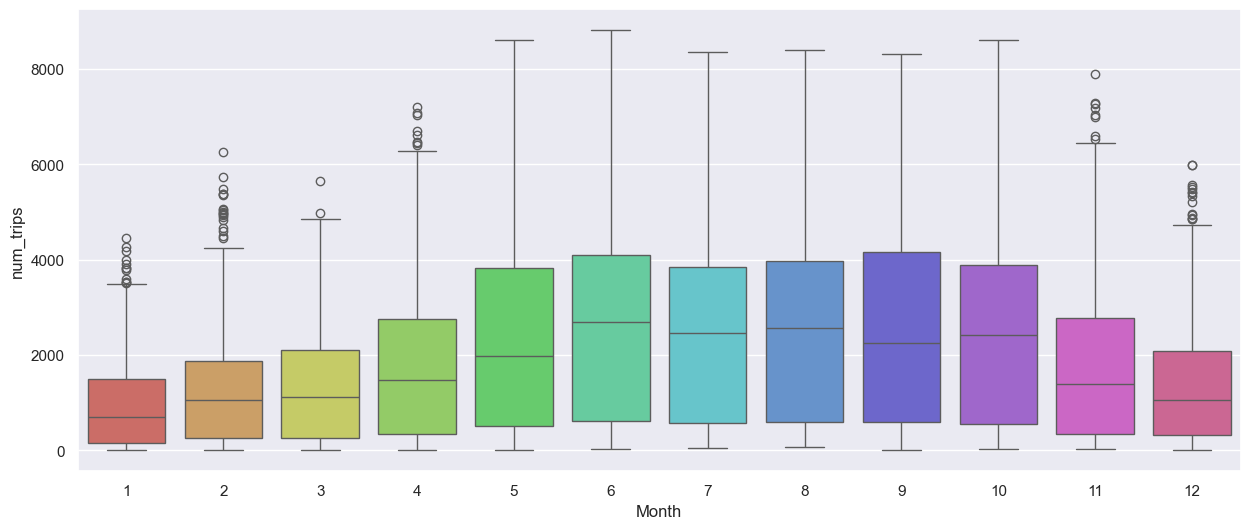

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
trips_per_hour_all['Month'] = trips_per_hour_all.index.month
sns.boxplot(data=trips_per_hour_all, x='Month', y='num_trips', ax=axes, hue='Month',palette=sns.color_palette("hls", 12),legend=False)
ax.set_ylabel('Number of trips')
ax.set_title('Boxplot of number of trips in each month')
plt.show()

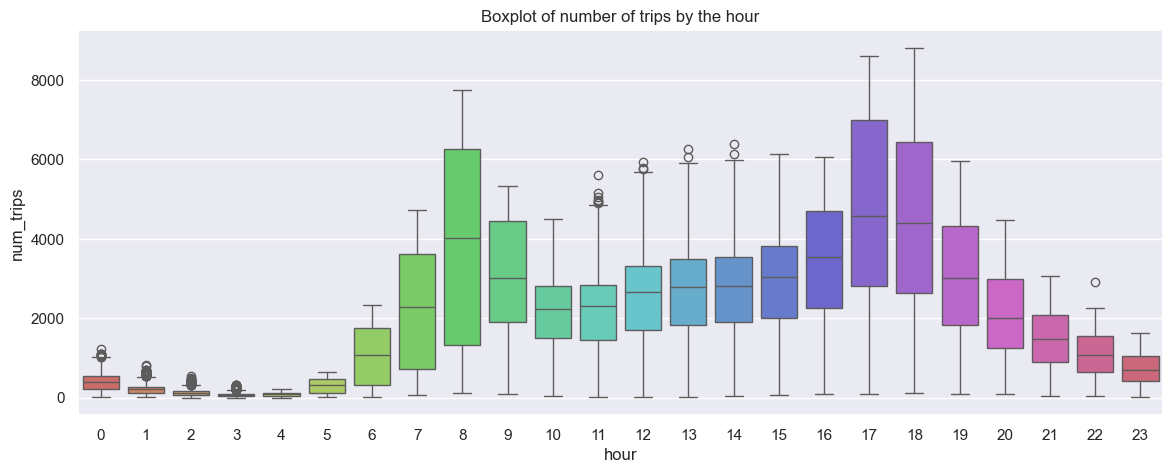

In [55]:
sns.boxplot(data=trips_per_hour_all, x='hour', y='num_trips',hue='hour',palette=sns.color_palette("hls", 24),legend=False)
plt.title('Boxplot of number of trips by the hour')
plt.show()

# Rolling average

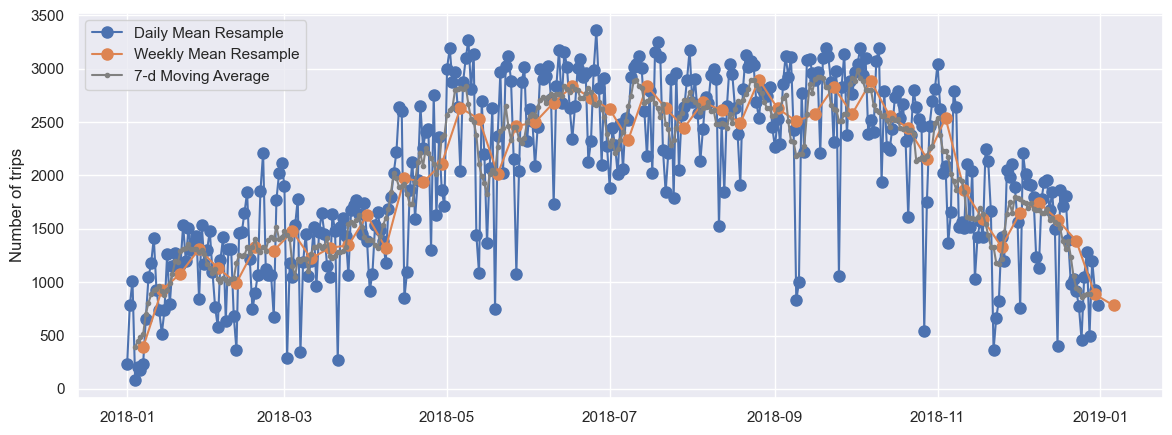

In [56]:
data_columns = ['num_trips']
opsd_daily_mean = trips_per_hour_all[data_columns].resample('D').mean()
opsd_daily_mean[:3]
opsd_weekly_mean = trips_per_hour_all[data_columns].resample('W').mean()
opsd_weekly_mean[:3]

opsd_7d = opsd_daily_mean[data_columns].rolling(7, center=True).mean()
opsd_7d.head(10)

start, end = '2018-01', '2019-01'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(opsd_daily_mean.loc[start:end, 'num_trips'],
marker='o', markersize=8, linestyle='-', label='Daily Mean Resample')
ax.plot(opsd_weekly_mean.loc[start:end, 'num_trips'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.plot(opsd_7d.loc[start:end, 'num_trips'],
marker='.', linestyle='-', label='7-d Moving Average', color="grey")
ax.set_ylabel('Number of trips')
ax.legend()

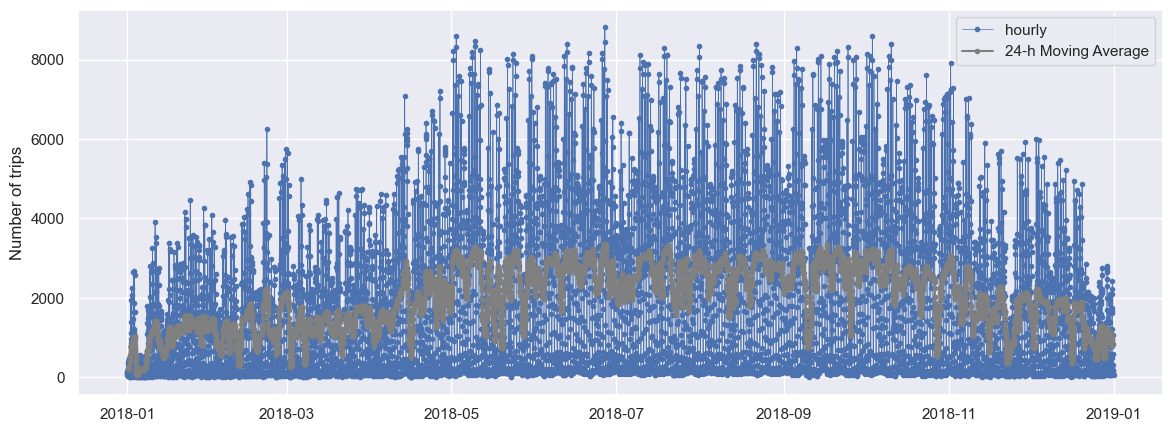

In [57]:

opsd_24h = trips_per_hour_all[data_columns].rolling(24, center=True).mean()
start, end = '2018-01', '2019-01'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(trips_per_hour_all.loc[start:end, 'num_trips'],
marker='.', linestyle='-', linewidth=0.5, label='hourly')
ax.plot(opsd_24h.loc[start:end, 'num_trips'],
marker='.', linestyle='-', label='24-h Moving Average', color="grey")
ax.set_ylabel('Number of trips')
ax.legend()

# Autocorrelation

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

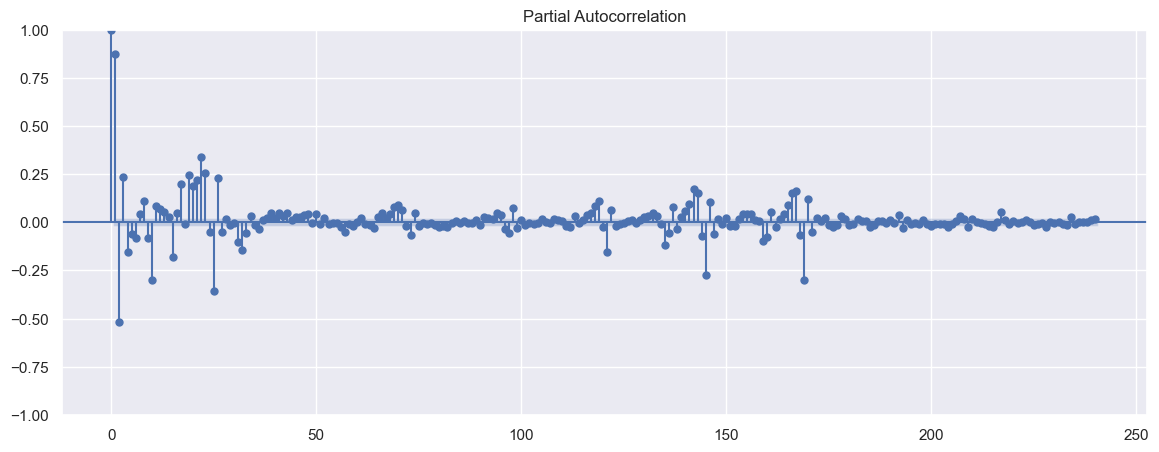

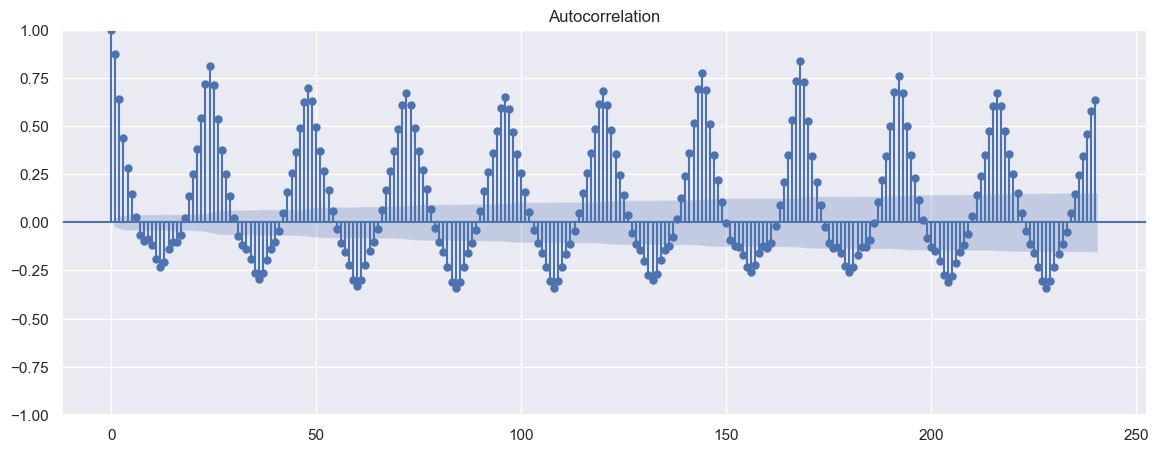

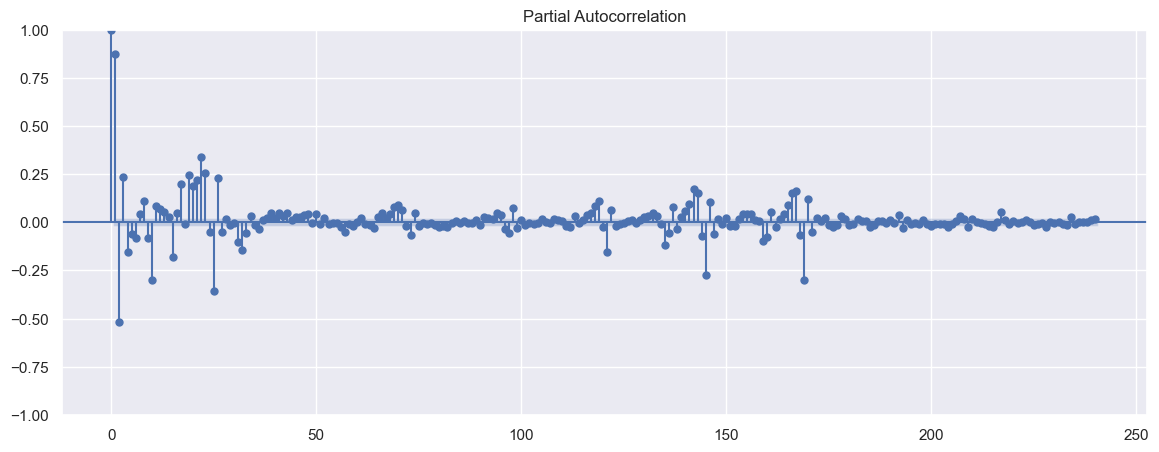

In [59]:
plot_acf(trips_per_hour_all['num_trips'],lags=10*24) # lags valgt udfra 10 dage gnage 24 timer
plot_pacf(trips_per_hour_all['num_trips'],lags=10*24)

# Further investigation of what variables to keep for our prediction model

We discussed: leaving out starttime, stoptime, and longitude and latitude for both end station and startstation. The spatial because we now just care which cluster we are in, therefore also leave out the stations ID. Starttime is relevant stop time not su much because we try to predict demand. ANd the trip duration will be kept, also weekend, birth year, most common usertype, and most common gender. Bike ID have also been left out as it seems irrelevant to know which bike goes where at this point. 

In [60]:


# Make sure starttime is a datetime
cluster_12_departures['starttime'] = pd.to_datetime(cluster_12_departures['starttime'])

# Extract date and hour
cluster_12_departures['date'] = cluster_12_departures['starttime'].dt.date
cluster_12_departures['hour'] = cluster_12_departures['starttime'].dt.hour

# Group by date and hour, count trips
trips_per_hour = cluster_12_departures.groupby(['date', 'hour'])
trips_per_hour.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,weekday,is_weekend,cluster,date,hour
Trip ID,,,,,,,,,,,,,,,,,,
493802,275,2018-01-01 10:20:07.330,2018-01-01 10:24:42.944,3118.0,40.735550,-73.952840,3119.0,40.742327,-73.954117,16417,Subscriber,1978,1,0,False,12.0,2018-01-01,10
493803,344,2018-01-01 11:31:47.933,2018-01-01 11:37:32.322,3118.0,40.735550,-73.952840,3119.0,40.742327,-73.954117,32458,Subscriber,1975,2,0,False,12.0,2018-01-01,11
493804,3632,2018-01-02 07:13:13.179,2018-01-02 08:13:45.342,3118.0,40.735550,-73.952840,3119.0,40.742327,-73.954117,16417,Subscriber,1978,1,1,False,12.0,2018-01-02,7
493805,2128,2018-01-02 07:26:05.037,2018-01-02 08:01:33.986,3118.0,40.735550,-73.952840,315.0,40.703554,-74.006702,32153,Subscriber,1967,2,1,False,12.0,2018-01-02,7
493806,432,2018-01-02 07:53:00.318,2018-01-02 08:00:12.926,3118.0,40.735550,-73.952840,3119.0,40.742327,-73.954117,31204,Subscriber,1983,1,1,False,12.0,2018-01-02,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17548021,1067,2018-12-31 20:32:17.711,2018-12-31 20:50:05.130,3654.0,40.751870,-73.933493,3514.0,40.776700,-73.927631,32047,Subscriber,1964,1,0,False,12.0,2018-12-31,20
17548080,153,2018-12-31 21:01:57.170,2018-12-31 21:04:30.584,3613.0,40.745038,-73.957539,3611.0,40.744907,-73.953457,32451,Subscriber,1977,1,0,False,12.0,2018-12-31,21
17548123,156,2018-12-31 21:26:09.661,2018-12-31 21:28:45.973,3613.0,40.745038,-73.957539,3119.0,40.742327,-73.954117,31247,Subscriber,1982,1,0,False,12.0,2018-12-31,21


In [61]:

grouped = (
    cluster_12_departures.groupby(['date', 'hour'])
      .agg(
          trip_count=('tripduration', 'count'),
          is_weekend=('is_weekend', 'first'),
          most_common_user_type=('usertype', lambda x: x.value_counts().index[0]),
          most_common_gender=('gender', lambda x: x.value_counts().index[0]),
          duration_mean=('tripduration', 'mean'),
          birth_mean=('birth_year', 'mean')
      )
      .reset_index()
)


In [62]:
grouped['datetime'] = pd.to_datetime(grouped['date'].astype(str)) + pd.to_timedelta(grouped['hour'], unit='h')
grouped.set_index('datetime', inplace=True)
grouped.drop(columns=['date'], inplace=True)
grouped.drop(columns=['hour'], inplace=True)

In [63]:
grouped

,trip_count,is_weekend,most_common_user_type,most_common_gender,duration_mean,birth_mean
datetime,,,,,,
2018-01-01 00:00:00,1,False,Subscriber,1,1763.0,1986.000000
2018-01-01 01:00:00,2,False,Subscriber,1,218.0,1979.500000
2018-01-01 02:00:00,2,False,Subscriber,1,377.5,1978.000000
2018-01-01 04:00:00,1,False,Subscriber,1,152.0,1985.000000
2018-01-01 07:00:00,1,False,Subscriber,1,141.0,1970.000000
...,...,...,...,...,...,...
2018-12-31 18:00:00,3,False,Subscriber,2,445.0,1972.666667
2018-12-31 19:00:00,2,False,Subscriber,1,517.5,1985.000000
2018-12-31 20:00:00,3,False,Subscriber,1,1174.0,1978.000000


# Starting to build model

## non stationarity - hjælp
Vi kan jo se nogle klare seasonalities - how to account for them

In [64]:
result = adfuller(trips_per_hour_all['num_trips'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.135703
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## Naive model - predict same val for trip_count as 24 h before

In [65]:
# Make sure the index is a DatetimeIndex
grouped.index = pd.to_datetime(grouped.index)

# Define the test start date
test_start = pd.Timestamp("2018-11-01")

# Create boolean masks
train_mask = grouped.index < test_start
test_mask  = grouped.index >= test_start


In [66]:
def plain_moving_average(series, n):
    #write your code here
    return list([np.average(series.iloc[max(i-n,0):i-1]) for i in range(1,len(series)+1)])

def plotprediction(series, pred_series, labels=["original", "predicted"], x_axis=None, plot_intervals=False, scale=1.96, plot_anomalies=False, title="prediction"):

    plt.figure(figsize=(15,5))
    plt.title(title)
    if x_axis is None:
        x_axis=series.index
    
    plt.plot(x_axis, pred_series, "g", label=labels[1])
    plt.plot(x_axis, series, label=labels[0])
    

    # Plot confidence intervals for smoothed values

    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

In [67]:
grouped['copy_pred'] = [0]*24 + grouped['trip_count'].to_list()[:-24]

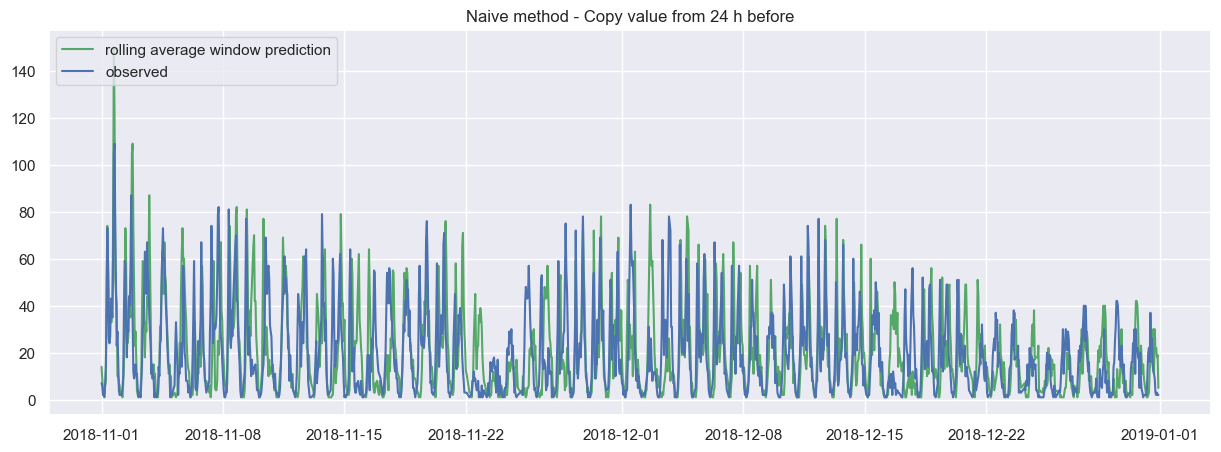

In [68]:
plotprediction(grouped[test_mask]['trip_count'], grouped[test_mask]['copy_pred'], labels=['observed', 'rolling average window prediction'], title="Naive method - Copy value from 24 h before")

### Eval. of Naive model

In [69]:
from sklearn.metrics import r2_score, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_stats(y_test, y_preds, title="You forgot the title!"):
    print(title+": ")
    print("\tr^2=%f"%r2_score(y_test,y_preds))
    print("\tMAE=%f"%mean_absolute_error(y_test,y_preds))
    print("\tMAPE=%f"%mean_absolute_percentage_error(y_test,y_preds))

In [70]:
print_stats(grouped[test_mask]['trip_count'], grouped[test_mask]['copy_pred'], "copy method")

copy method: 
	r^2=-0.137736
	MAE=13.706056
	MAPE=137.853850


# Trying to do an ARIMA model
### Be aware that for this ARIMA model we only use trip_count as variable to predict - not weekend or any of the others

So QUESTIONS:
Can we get categorical (or event just more data) in the arima model?
How to choose parameters for p,q and d? 

Det kan være at ARIMA med tuning kan blive godt, men Lineær Regression kan muligvis opnå lignende resultater med mindre besvær. -(Konklusion fra kaggle-linket)

In [71]:
from statsmodels.tsa.arima.model import ARIMA

In [72]:
grouped_data = pd.DataFrame(grouped.trip_count.copy())
grouped_data


,trip_count
datetime,
2018-01-01 00:00:00,1
2018-01-01 01:00:00,2
2018-01-01 02:00:00,2
2018-01-01 04:00:00,1
2018-01-01 07:00:00,1
...,...
2018-12-31 18:00:00,3
2018-12-31 19:00:00,2
2018-12-31 20:00:00,3


In [73]:
data=grouped_data[train_mask]
model=ARIMA(data, order=(24, 0, 0))
AR=model.fit()
print(AR.summary())

/opt/homebrew/Caskroom/miniconda/base/envs/business-analytics2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/business-analytics2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/business-analytics2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             trip_count   No. Observations:                 6800
Model:                ARIMA(24, 0, 0)   Log Likelihood              -26711.359
Date:                Mon, 24 Nov 2025   AIC                          53474.718
Time:                        13:51:06   BIC                          53652.160
Sample:                             0   HQIC                         53535.951
                               - 6800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.6891      2.813     10.199      0.000      23.176      34.202
ar.L1          0.8921      0.009     97.390      0.000       0.874       0.910
ar.L2         -0.2074      0.013    -16.527      0.0

Kan man få Sarima til at tage højde for is_weekend? 
When testing the model - we can update one day at a time? So after we predicted for a day we add the actual values for that day and then try to predict the next one?

# ARIMA 2.0

In [74]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

lags_to_plot = 72

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

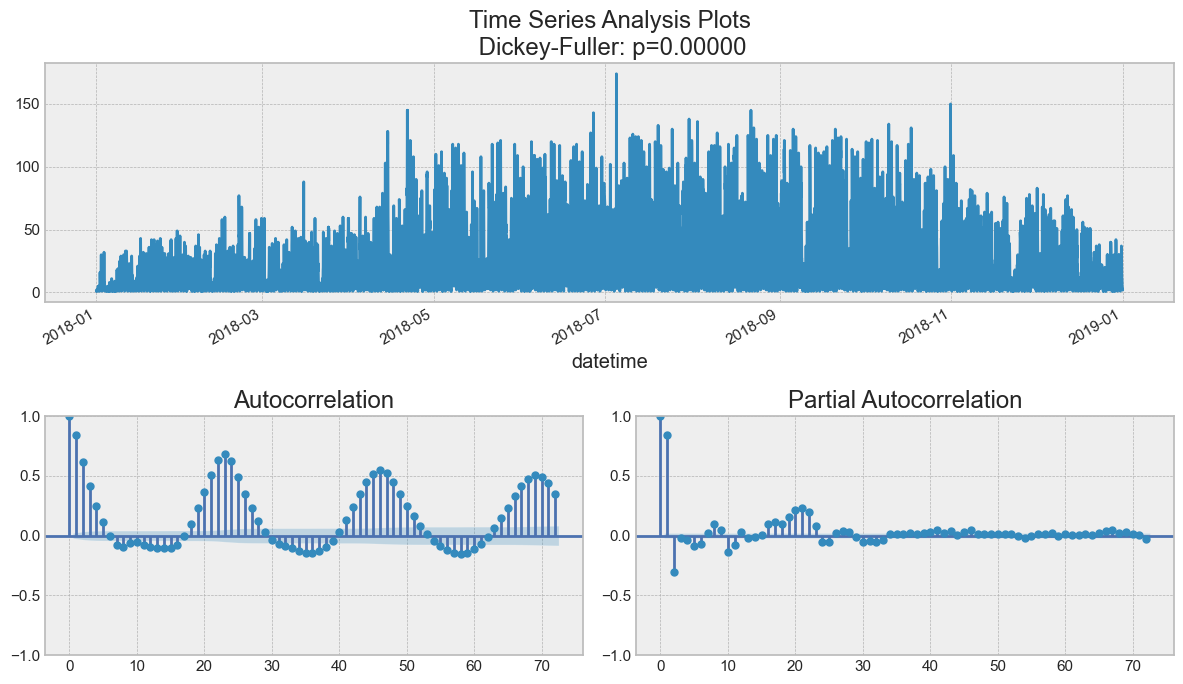

In [75]:
tsplot(grouped_data.trip_count, lags=lags_to_plot)

# Adjusting for daily seasonality: 

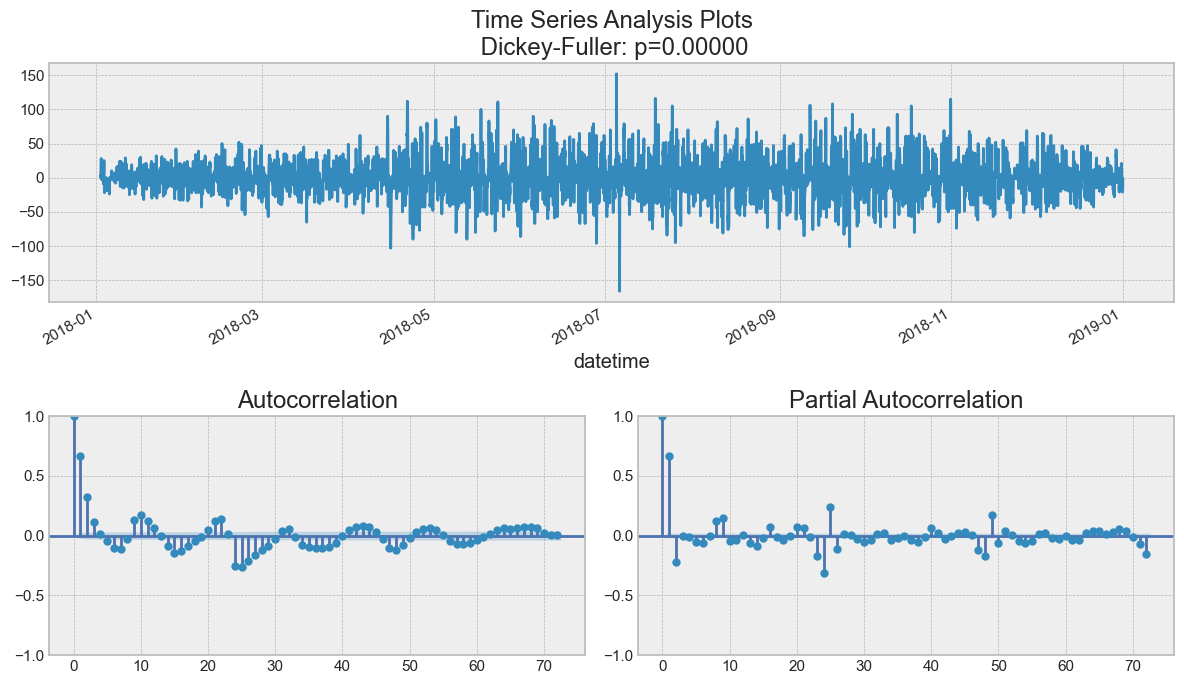

In [76]:
trip_diff = grouped_data.trip_count - grouped_data.trip_count.shift(24)
tsplot(trip_diff[24:], lags=lags_to_plot)

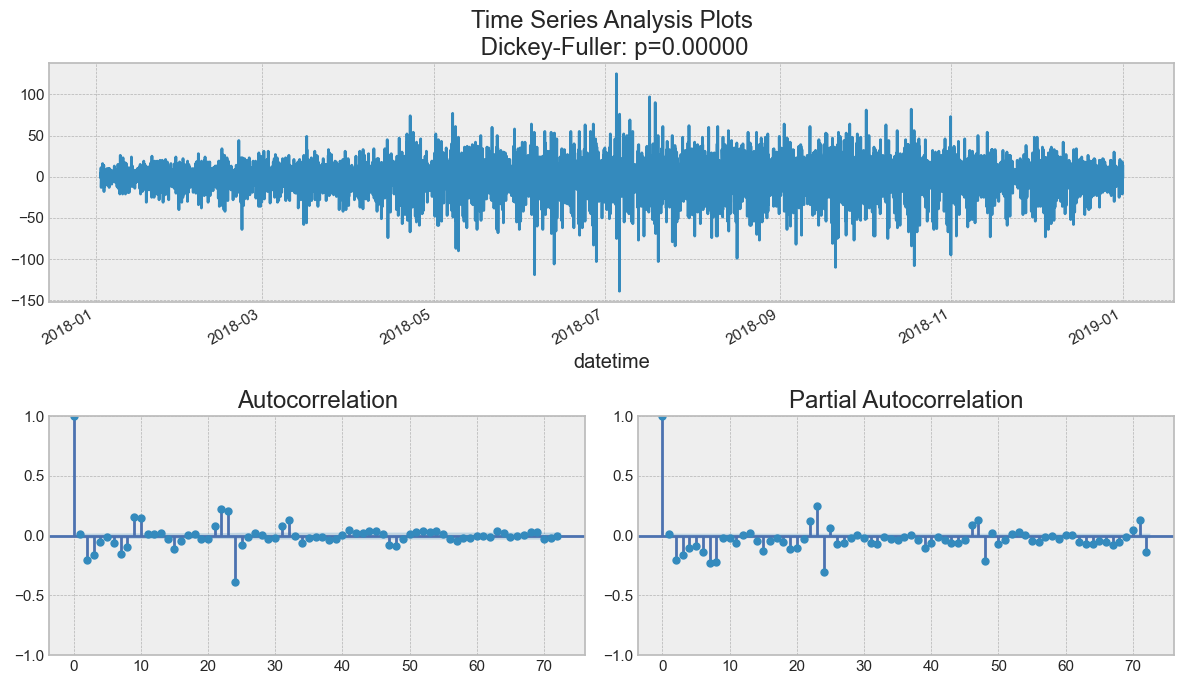

In [77]:
trip_diff = trip_diff - trip_diff.shift(1)
tsplot(trip_diff[24+1:], lags=lags_to_plot)

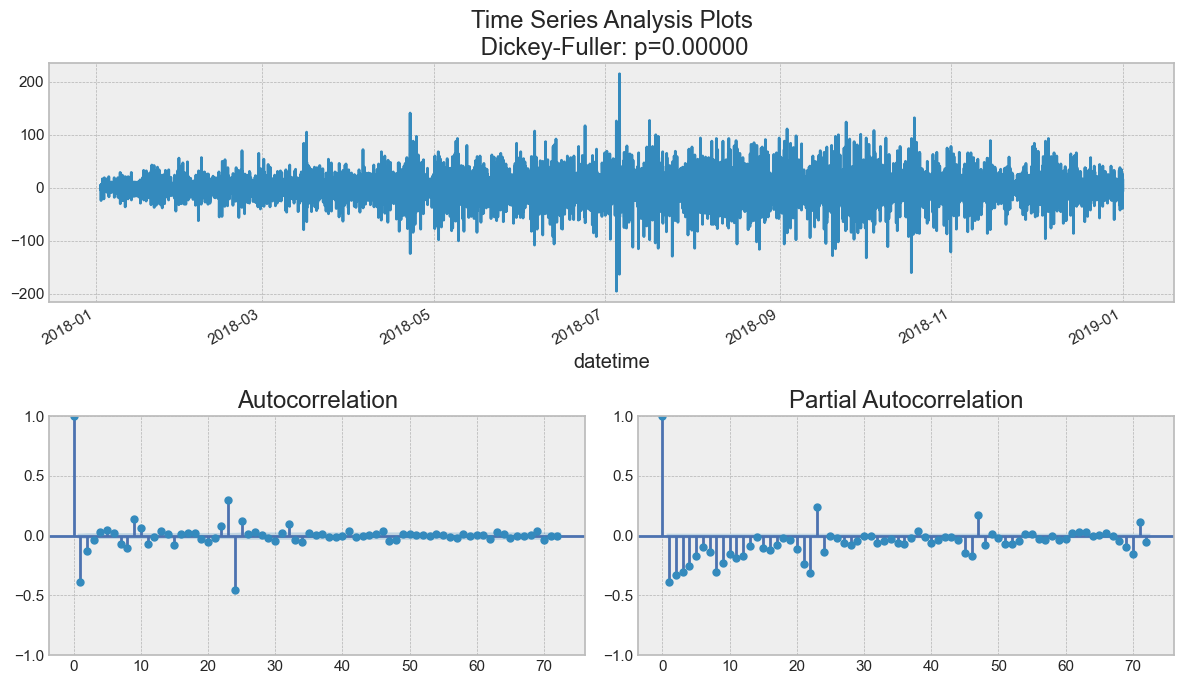

In [78]:
trip_diff = trip_diff - trip_diff.shift(1)
trip_clean = trip_diff[25:].replace([np.inf, -np.inf], np.nan).dropna()
tsplot(trip_clean, lags=lags_to_plot)

In [ ]:
from itertools import product
ps = range(1, 6)
d=1
qs = range(1, 3)
Ps = range(1, 7)
D=0 
Qs = range(1, 3)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

120

In [ ]:
'''
from tqdm import tqdm_notebook
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table
    ''' # Kode from Kaggle - does not use 

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd

# --- simple split ---
val_start = pd.Timestamp("2018-10-01")
test_start = pd.Timestamp("2018-11-01")

# Create boolean masks
train_mask = grouped.index < test_start
test_mask  = grouped.index >= test_start
val_mask = (grouped.index <= test_start)&(grouped.index>val_start)
train = grouped_data[train_mask]
val = grouped_data[val_mask]
test = grouped_data[test_mask]


results = []

for param in parameters_list:
    try:
        model = SARIMAX(
            train,
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], s)
        ).fit(disp=False)
    except:
        continue

    # --- Training MSE ---
    train_pred = model.fittedvalues
    train_mse = np.mean((train - train_pred) ** 2)

    # --- Validation MSE ---
    val_forecast = model.forecast(steps=len(val))
    val_mse = np.mean((val - val_forecast) ** 2)

    results.append([param, train_mse, val_mse])

# --- Put results in a table ---
result_table = pd.DataFrame(results, columns=["parameters", "train_mse", "val_mse"])

# Sort by validation performance (lower is better)
result_table = result_table.sort_values(by='val_mse').reset_index(drop=True)

result_table


/opt/homebrew/Caskroom/miniconda/base/envs/business-analytics2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/business-analytics2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/business-analytics2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniconda/base/envs/business-analytics2/lib/python3.11/site-packages/statsmodels/tsa/ba